In [1]:
%load_ext rpy2.ipython
import os
os.chdir('scRTE/scripts')
from common import *
load_sc_data()

In [ ]:
%%R
if(getwd()!='/home/wdeng3/workspace/Codespace/scRTE/scripts'){
    setwd('/home/wdeng3/workspace/Codespace/scRTE/scripts')
}
source('common.r')

## Disease stage inference from RTE expression

In [5]:
sfg_ad=pd.read_csv('../data/all_datasets/AD_HS_00003.1.cell_exp.txt',sep='\t',index_col=0)
sfg_umap=pd.read_csv('../data/all_datasets/AD_HS_00003.1.cell_umap.txt',sep='\t',index_col=0)
colnames=sfg_ad.columns
repl_colnames=[]
for x in colnames:
    if '.' not in x or x not in genes_rep:
        repl_colnames.append(x)
    else:
        repl_colnames.append(genes[genes_rep.index(x)])

sfg_ad.columns=repl_colnames

sfg_ad['Diagnosis']=sfg_umap['Diagnosis']
sfg_ad['predicted.celltype']=sfg_umap['predicted.celltype']
sfg_ad['UMAP_1']=sfg_umap['UMAP_1']
sfg_ad['UMAP_2']=sfg_umap['UMAP_2']

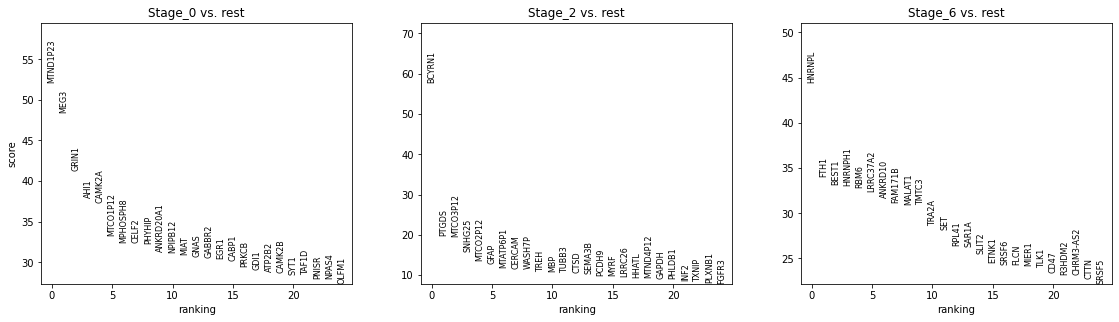

In [6]:
ex_=sfg_ad.loc[sfg_ad['predicted.celltype']=='Ex',[x for x in sfg_ad.columns if x not in rtes]]
adata=anndata.AnnData(X=np.expm1(ex_.iloc[:,:-4]))

adata.obs['Diagnosis']=ex_['Diagnosis']
adata.obs['CellType']=ex_['predicted.celltype']
adata.obsm['X_umap']=ex_[['UMAP_1','UMAP_2']].to_numpy()
adata.var["mito"] = adata.var_names.str.startswith("MT-")
adata.layers["counts"] = adata.X.copy()
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# fig,axs=plt.subplots(1,3,figsize=[45,8])

non_mito=np.invert(adata.var_names.str.startswith("MT-"))
adata=adata[:,non_mito]
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)
sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata, color='CellType')
sc.tl.rank_genes_groups(adata, 'Diagnosis', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
gene_markers=[]
marker_list=np.array(adata.uns['rank_genes_groups']['names'].tolist()).flatten()
for i in marker_list:
    if i not in gene_markers:
        gene_markers.append(i)
extended_markers=gene_markers[:730*2]
gene_markers=gene_markers[:730]

### Compare ML models

#### RTE only

In [ ]:
### Prepare data
cell='Ex'
cell_exp=sfg_ad.loc[sfg_ad['predicted.celltype']==cell,:]
cell_exp.iloc[:,:-4]=np.expm1(cell_exp.iloc[:,:-4].astype(float))
rte_exp=cell_exp[[x for x in cell_exp.columns if x in rtes]]
factors=pd.factorize(cell_exp['Diagnosis'])
labels=factors[0]

### Define models
classifiers = [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(n_estimators=100,random_state=42),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))]
names = [
    "RBF SVM",
    "Random Forest",
    "AdaBoost",
    "MLP"
]
colors=['#386cb0','#fdb462','#7fc97f','#ef3b2c','#662506','#a6cee3','#fb9a99','#984ea3','#ffff33','#6060f4','#ad27ad']

### Cross validation
scores=[cv_auc(classifiers,names,rte_exp.to_numpy(),labels,'RTE730',i,color=colors[i]) for i in range(len(classifiers))]

### Indenpendent testing
definitions=factors[1]
x_train,x_test,y_train,y_test = train_test_split(rte_exp.to_numpy(),labels,test_size=0.2,random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


for i in range(len(classifiers)):
    cls = classifiers[i]
    cls.fit(x_train, y_train)

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
t_labels=['Stage_6','Stage_2','Stage_0']
for i in range(len(classifiers)):
    cls = classifiers[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_rte_cm.csv',index=True,header=True)

importances = classifiers[1].feature_importances_
importances=pd.Series(importances, index=rte_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers[1].estimators_], axis=0),index=rte_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/rte_importances.csv',index=True,header=True)

[1] "RBF SVM"
[1] "Random Forest"


[1] "AdaBoost"
[1] "MLP"
png 
  2 


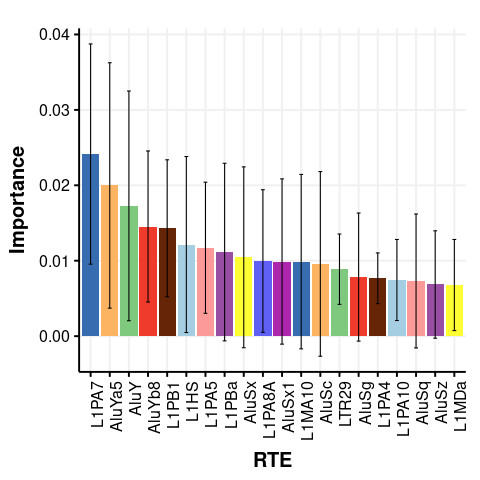

In [10]:
%%R
ps<-list()
pdf('../data/analysis/figures/rte_cm.pdf')

for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     print(name)
     df<-read.csv(paste0('../data/analysis/models/',name,'_rte_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
          cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
          show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
          bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
          show_row_names = FALSE,
          heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
          rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     print(p)
}

dev.off()

df<-read.csv('../data/analysis/rte_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Importance')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/rte_importances.pdf')
print(p)
dev.off()

#### Gene only

In [38]:
gene_exp=cell_exp.loc[:,gene_markers]

### Define models
classifiers_gene= [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
scores_gene730=[cv_auc(classifiers_gene,names,gene_exp.to_numpy(),labels,'Gene730',i,color=colors[i]) for i in range(len(classifiers_gene))]

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(gene_exp.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

for i in range(len(classifiers_gene)):
    cls = classifiers_gene[i]
    cls.fit(x_train, y_train)


# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
t_labels=['Stage_6','Stage_2','Stage_0']
for i in range(len(classifiers_gene)):
    cls = classifiers_gene[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_gene_cm.csv',index=True,header=True)

importances = classifiers_gene[1].feature_importances_
importances=pd.Series(importances, index=gene_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers_gene[1].estimators_], axis=0),
                                              index=gene_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/gene_importances.csv',index=True,header=True)

RBF SVM 0.847457627118644 22420 7561 8373 6486
Random Forest 0.8307314897413024 22420 7561 8373 6486
AdaBoost 0.7636039250669046 22420 7561 8373 6486
MLP 0.8592774308652988 22420 7561 8373 6486


In [20]:
%%R
ps<-list()
pdf('../data/analysis/figures/gene_cm.pdf')

for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     df<-read.csv(paste0('../data/analysis/models/',name,'_gene_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
             cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
             show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
             bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
             show_row_names = FALSE,
        heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
        rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     draw(p)
     ps[[length(ps)+1]]<-p
#      break
}
for(p in ps){
    draw(p)
}
dev.off()

df<-read.csv('../data/analysis/gene_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/gene_importances.pdf')
print(p)
dev.off()

png 
  2 


## RFE to select features

In [ ]:
feature_num=[[50,100],[100,100],[100,200],[200,200],[200,300],[300,300],[300,400],[400,400],[400,500],[500,500]]
classifiers_rfe= [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]
for n_features_to_select,n_features_to_select_from in feature_num:
    # n_features_to_select,n_features_to_select_from=50,100#int(sys.argv[1]),int(sys.argv[2])
    cell_exp=pd.read_csv('../data/analysis/combined_exp1460.txt',sep='\t')
    sfg_umap=pd.read_csv('../data/all_datasets/AD_HS_00003.1.cell_umap.txt',sep='\t',index_col=0)
    sfg_umap=sfg_umap.loc[sfg_umap['predicted.celltype']=='Ex',:]
    factors=pd.factorize(sfg_umap['Diagnosis'])
    labels=factors[0]

    clmns=list(cell_exp.columns)
    valid_features=clmns[:n_features_to_select_from]
    valid_features.extend(clmns[730:730+n_features_to_select_from])
    rfe = RFE(estimator=RandomForestClassifier(n_estimators=100,random_state=42), n_features_to_select=n_features_to_select)
    model=RandomForestClassifier(n_estimators=100,random_state=42)
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    cv_auc_core(pipeline,cell_exp[valid_features].to_numpy(),labels,
                '../data/analysis/models_rfe%s_%s/cv10.pdf'%(n_features_to_select,n_features_to_select_from))

    pipeline.fit(cell_exp[valid_features].to_numpy(),labels)
    importances = pipeline.named_steps['m'].feature_importances_

    index=list(compress(valid_features,list(pipeline[0].support_)))
    importances=pd.Series(importances, index=index)
    importances=pd.concat([importances, 
                        pd.Series(np.std([tree.feature_importances_ for tree in pipeline.named_steps['m'].estimators_], axis=0),
                                    index=index)], axis=1)
    importances.columns=['Importance','STD']

    importances=importances.sort_values(by='Importance',ascending=False)
    importances_=importances.iloc[:n_features_to_select,:]
    importances_.to_csv('../data/analysis/rfe_%s_%s.csv'%(n_features_to_select,n_features_to_select_from),index=True,header=True)

    scores = cross_val_score(pipeline, cell_exp[valid_features].to_numpy(),labels, scoring='accuracy', 
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42) , n_jobs=-1, error_score='raise')
    series=pd.Series(scores)
    series.to_csv('../data/analysis/rfe_%s_%s_acc.csv'%(n_features_to_select,n_features_to_select_from),index=False,header=False)

#### Plot mean acc of different feature numbers

In [17]:
feature_num=[[50,100],[100,100],[100,200],[200,200],[200,300],[300,300],[300,400],[400,400],[400,500],[500,500]]
accs=[]
valid_fn=[]
for features in feature_num:
    if os.path.isfile(f'../data/analysis/rfe_{features[0]}_{features[1]}_acc.csv'):
        print(f'loading data: {features} \n')
        valid_fn.append(features)
        accs.append(pd.read_csv(f'../data/analysis/rfe_{features[0]}_{features[1]}_acc.csv',header=None).values.ravel())
    elif os.path.isfile(f'../data/analysis/rfe_RF_{features[0]}_{features[1]}_acc.csv'):
        print(f'loading data: {features} \n')
        valid_fn.append(features)
        accs.append(pd.read_csv(f'../data/analysis/rfe_RF_{features[0]}_{features[1]}_acc.csv',header=None).values.ravel())

accs=pd.DataFrame(accs)

accs=accs.transpose()
clmns=[f'n={x[0]} N={x[1]}' for x in valid_fn]
accs.columns=clmns
accs.to_csv('../data/analysis/rfe_accs.csv',sep='\t',index=False,header=True)

loading data: [50, 100] 

loading data: [100, 100] 

loading data: [100, 200] 

loading data: [200, 200] 

loading data: [200, 300] 

loading data: [300, 300] 

loading data: [300, 400] 

loading data: [400, 400] 

loading data: [400, 500] 

loading data: [500, 500] 



R[write to console]: No id variables; using all as measure variables



png 
  2 


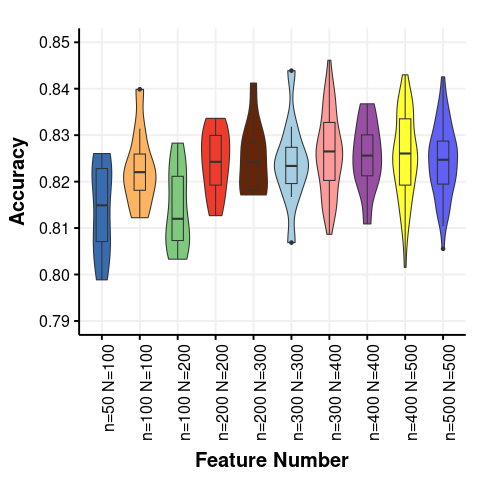

In [35]:
%%R
library(reshape2)
df<-read.csv('../data/analysis/rfe_accs.csv',sep='\t',header=T,check.names =F)
meltdf<-melt(df)
colnames(meltdf)<-c('FeatureN','Accuracy')

p<-ggplot(data=meltdf,aes(x=FeatureN,y=Accuracy,fill=FeatureN))+geom_violin()+theme_Publication()+
 scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+
 xlab('Feature Number')+ylab('Accuracy')+scale_y_continuous(limits=c(0.79,0.85),breaks=seq(0.79,0.85,by=0.01))+
 geom_boxplot(width=0.3)
print(p)
pdf('../data/analysis/figures/rfe_acc.pdf')
print(p)
dev.off()

png 
  2 


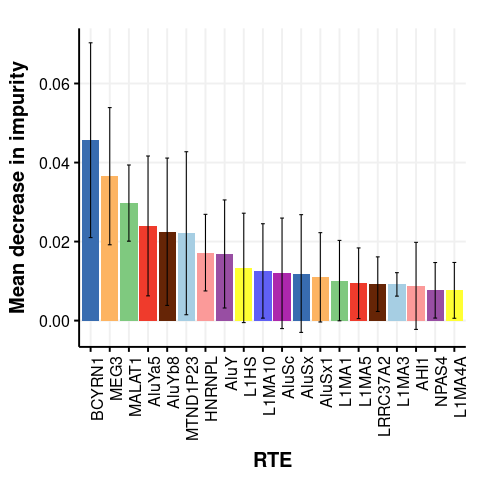

In [37]:
%%R
df<-read.csv('../data/analysis/rfe_RF_200_200.csv')
df<-df[0:20,]
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+
 theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/rfe_RF_200_200.pdf')
print(p)
dev.off()